# Examples of using DBFE

In [1]:
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import dbfe

In [2]:
variant_type = "DEL"
pos_class = "RES"

stat_vals = pd.read_csv(f"../experiments/data/ovarian/ovarian_cnv.csv.gz", index_col='SAMPLEID')
stat_vals = stat_vals.loc[stat_vals.SVCLASS == variant_type, :]
stat_vals = stat_vals.groupby(stat_vals.index)['LEN'].apply(list).to_frame()

labels = pd.read_csv(f"../experiments/data/ovarian/labels.tsv", sep='\t', index_col=0)
labels = (labels == pos_class) * 1  # NONRES == 0, RES == 1
stat_df = stat_vals.join(labels.CLASS_LABEL, how='inner')

stat_df

,LEN,CLASS_LABEL
AOCS-001-1,"[15042483, 331439, 3964684, 164592, 209090, 13...",0
AOCS-004-1,"[43470, 50089, 4621, 447396, 44482, 13584, 205...",0
AOCS-005-1,"[528900, 69282, 141248, 926831, 2508859, 50596...",0
AOCS-034-1,"[516668, 99479, 2455919, 12415179, 6877711, 38...",1
AOCS-055-1,"[503343, 105211, 237909, 297935, 54542, 275263...",0
...,...,...
TCGA-36-1570,"[37248, 198462, 11435934, 21717737, 7998166, 1...",1
TCGA-36-1571,"[44211, 335207, 315813, 2516724, 631985, 15648...",1
TCGA-36-1574,"[26054, 10585377, 47714, 1990, 356342, 4932892...",1
TCGA-61-2000,"[122287, 512304, 78553, 77328, 48860, 115082, ...",0


In [3]:
X = stat_df.loc[:, "LEN"]
y = stat_df.loc[:, "CLASS_LABEL"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23, stratify=y)

## Using DBFE in a scikit-learn pipeline

AUC on test data: 0.614


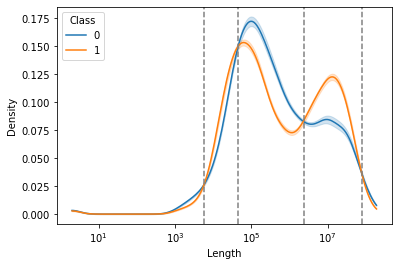

In [4]:
extractor = dbfe.DistributionBasedFeatureExtractor(breakpoint_type='supervised', n_bins='auto', cv=10)
pipe = make_pipeline(extractor, StandardScaler(), LogisticRegression())
pipe.fit(X_train, y_train)

fig = plt.figure()
ax = fig.add_subplot(111)
extractor.plot_data_with_breaks(X_train, y_train, plot_type='kde', plot_ax=ax, subplot=True);
figure = ax.get_figure()
figure.savefig("img/dbfe_plot.svg");

y_prob = pipe.predict_proba(X_test)
print("AUC on test data: {:.3}".format(roc_auc_score(y_test, y_prob[:, 1])))

## Extracting features

In [5]:
extractor = dbfe.DistributionBasedFeatureExtractor(breakpoint_type='supervised', n_bins='auto', 
                                                   include_counts=True, include_fracs=True, include_total=True)
extractor.fit_transform(X_train, y_train)

,dbfe_0_5891,dbfe_5891_44920,dbfe_44920_2381094,dbfe_2381094_79544511,dbfe_79544511_inf,total_dbfe,frac_dbfe_0_5891,frac_dbfe_5891_44920,frac_dbfe_44920_2381094,frac_dbfe_2381094_79544511,frac_dbfe_79544511_inf
TCGA-25-1634,3,3,9,2,1,18,0.166667,0.166667,0.500000,0.111111,0.055556
HMF003013A,0,2,15,6,0,23,0.000000,0.086957,0.652174,0.260870,0.000000
TCGA-04-1514,4,14,24,6,0,48,0.083333,0.291667,0.500000,0.125000,0.000000
HMF003031A,1,2,16,5,0,24,0.041667,0.083333,0.666667,0.208333,0.000000
HMF002439A,1,12,89,3,0,105,0.009524,0.114286,0.847619,0.028571,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
HMF001136A,3,10,12,1,0,26,0.115385,0.384615,0.461538,0.038462,0.000000
HMF003205A,2,11,42,34,0,89,0.022472,0.123596,0.471910,0.382022,0.000000
HMF000280A,0,4,11,14,2,31,0.000000,0.129032,0.354839,0.451613,0.064516
AOCS-139-4,6,14,53,14,0,87,0.068966,0.160920,0.609195,0.160920,0.000000


## Using different DBFE approaches

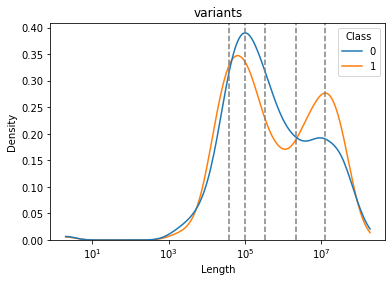

In [6]:
extractor_quantile = dbfe.DistributionBasedFeatureExtractor(breakpoint_type='quantile', n_bins=6)
extractor_quantile.fit(X_train, y_train)
extractor_quantile.plot_data_with_breaks(X_train, y_train, plot_type='kde');

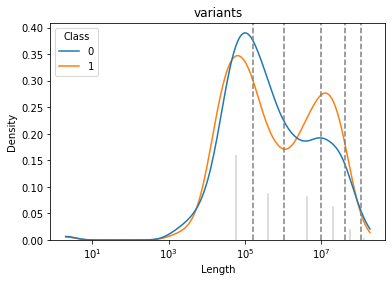

In [7]:
extractor_clustering = dbfe.DistributionBasedFeatureExtractor(breakpoint_type='clustering', n_bins=6, random_state=23)
extractor_clustering.fit(X_train, y_train)
extractor_clustering.plot_data_with_breaks(X_train, y_train, plot_type='kde');

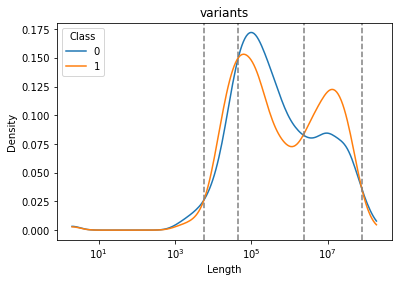

In [8]:
extractor_supervised = dbfe.DistributionBasedFeatureExtractor(breakpoint_type='supervised', n_bins='auto')
extractor_supervised.fit(X_train, y_train)
extractor_supervised.plot_data_with_breaks(X_train, y_train, plot_type='kde');

## Alternative DBFE plots

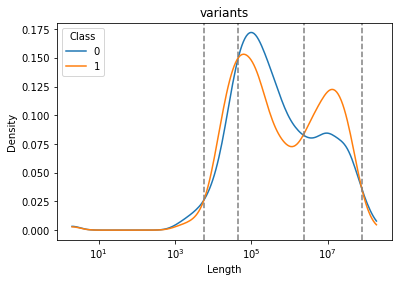

In [9]:
extractor = dbfe.DistributionBasedFeatureExtractor(breakpoint_type='supervised', n_bins='auto')
extractor.fit(X_train, y_train)
extractor.plot_data_with_breaks(X_train, y_train, plot_type='kde');

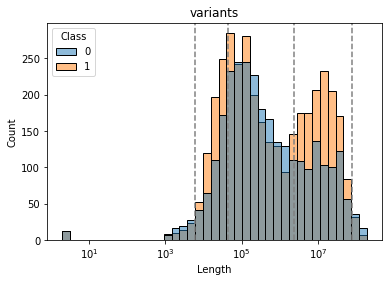

In [10]:
extractor.plot_data_with_breaks(X_train, y_train, plot_type='hist');